<a href="https://colab.research.google.com/github/NichBry25/BitcoinPricePrediction/blob/main/BTCForecasting_GRU_Based_DeepVAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Ensures results are replicable

import os
os.environ["PYTHONHASHSEED"] = "42"
os.environ["TF_DETERMINISTIC_OPS"] = "1"
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import random

In [3]:
# Ensures results are replicable

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [4]:
df = pd.read_csv('btc_forecasting_dataset3.csv')

In [5]:
df

,Date,btc_price,open,high,low,volume,spx_price,xau_price,vix_price,dxy_price,...,xau_logret_lag3,xau_logret_lag7,vix_logret_lag1,vix_logret_lag3,vix_logret_lag7,dxy_logret_lag1,dxy_logret_lag3,dxy_logret_lag7,btc_ma50,btc_ma200
0,2015-07-20,277.7,273.2,278.9,271.8,46600.0,2128.30,1096.95,12.25,98.03,...,-0.009696,-0.005134,0.000000,-0.013300,-0.191274,0.000000,0.001943,0.008606,252.782,246.4990
1,2015-07-21,275.1,277.7,281.0,274.2,49050.0,2119.20,1101.41,12.22,97.33,...,0.000000,-0.002135,0.024795,0.000000,-0.038875,0.001736,0.000000,-0.002274,253.822,246.2985
2,2015-07-22,276.5,275.1,277.4,273.1,41970.0,2114.20,1093.45,12.12,97.60,...,0.000000,-0.005102,-0.002452,0.000000,-0.010526,-0.007166,0.000000,0.005469,254.838,246.2455
3,2015-07-23,275.5,276.5,277.9,274.5,35660.0,2102.20,1090.80,12.64,97.11,...,-0.033306,-0.003922,-0.008217,0.024795,-0.088455,0.002770,0.001736,0.005132,255.836,246.2995
4,2015-07-24,288.4,275.5,289.8,274.3,74360.0,2079.70,1099.10,13.74,97.24,...,0.004058,-0.009696,0.042009,-0.002452,-0.013300,-0.005033,-0.007166,0.001943,257.120,246.3675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3752,2025-10-27,114108.0,114553.9,116307.5,113868.0,70790.0,6875.16,3981.59,15.79,98.78,...,-0.003416,0.024755,0.000000,-0.055256,-0.130922,0.000000,0.000101,0.001624,114272.866,108948.3695
3753,2025-10-28,112905.8,114110.3,116076.7,112266.9,52490.0,6890.89,3952.58,16.42,98.67,...,0.000000,-0.054579,-0.036074,0.000000,-0.019945,-0.001720,0.000000,0.003443,114289.614,109095.8330
3754,2025-10-29,110024.6,112904.7,113628.7,109506.4,66990.0,6890.59,3930.38,16.92,99.22,...,0.000000,-0.007551,0.039123,0.000000,0.040038,-0.001114,0.000000,-0.000303,114259.776,109219.4925
3755,2025-10-30,108320.1,110024.9,111585.8,106371.4,80070.0,6822.34,4024.47,16.91,99.53,...,-0.032253,0.007810,0.029996,-0.036074,-0.072455,0.005559,-0.001720,0.000404,114146.908,109342.4210


Grouping columns with or without macroeconomic features based on number ("1" for WITHOUT, and "2" for WITH)

In [6]:
TARGET = 'btc_logret'

In [7]:
FEATURES_1 = [
    "btc_price", "open", "high", "low", "volume",
    "btc_ma50", "btc_ma200"
]

In [8]:
FEATURES_2 = [
    "btc_price","open","high","low","volume",
    "spx_price","xau_price","vix_price","dxy_price",
    "spx_logret","xau_logret","vix_logret","dxy_logret",
    "spx_logret_lag1","spx_logret_lag3","spx_logret_lag7",
    "xau_logret_lag1","xau_logret_lag3","xau_logret_lag7",
    "vix_logret_lag1","vix_logret_lag3","vix_logret_lag7",
    "dxy_logret_lag1","dxy_logret_lag3","dxy_logret_lag7",
    "btc_ma50","btc_ma200"
]

# Train - Val - Test Split

In [9]:
total_len = len(df)

In [10]:
train_end = int(total_len * 0.7)
val_end = int(total_len * 0.85)

train_df = df.iloc[:train_end].copy()
val_df   = df.iloc[train_end:val_end].copy()
test_df  = df.iloc[val_end:].copy()

In [11]:
train_df.shape

(2629, 29)

In [12]:
val_df.shape

(564, 29)

In [13]:
test_df.shape

(564, 29)

# Scale Features

In [14]:
scaler_1 = MinMaxScaler()

In [15]:
scaler_1.fit(train_df[FEATURES_1])

MinMaxScaler()

In [16]:
train_scaled_1 = scaler_1.transform(train_df[FEATURES_1])
val_scaled_1   = scaler_1.transform(val_df[FEATURES_1])
test_scaled_1  = scaler_1.transform(test_df[FEATURES_1])

In [17]:
scaler_2 = MinMaxScaler()

In [18]:
scaler_2.fit(train_df[FEATURES_2])

MinMaxScaler()

In [19]:
train_scaled_2 = scaler_2.transform(train_df[FEATURES_2])
val_scaled_2   = scaler_2.transform(val_df[FEATURES_2])
test_scaled_2  = scaler_2.transform(test_df[FEATURES_2])

In [20]:
# Target scaler
y_train_full = train_df[TARGET].values
y_val_full   = val_df[TARGET].values
y_test_full  = test_df[TARGET].values

In [21]:
target_scaler = StandardScaler()

In [22]:
target_scaler.fit(y_train_full.reshape(-1, 1))

StandardScaler()

In [23]:
y_train_scaled = target_scaler.transform(y_train_full.reshape(-1, 1)).ravel()
y_val_scaled   = target_scaler.transform(y_val_full.reshape(-1, 1)).ravel()
y_test_scaled  = target_scaler.transform(y_test_full.reshape(-1, 1)).ravel()

# Create Sequence

In [24]:
def make_sequence_data(values, target, lookback):
    X, y = [], []
    for i in range(lookback, len(values)):
        X.append(values[i - lookback:i])
        y.append(target[i])
    return np.array(X), np.array(y)

In [25]:
LOOKBACK = 60

In [26]:
X_train_1, y_train_1 = make_sequence_data(train_scaled_1, y_train_scaled, LOOKBACK)
X_val_1,   y_val_1   = make_sequence_data(val_scaled_1,   y_val_scaled,   LOOKBACK)
X_test_1,  y_test_1  = make_sequence_data(test_scaled_1,  y_test_scaled,  LOOKBACK)

In [27]:
X_train_2, y_train_2 = make_sequence_data(train_scaled_2, y_train_scaled, LOOKBACK)
X_val_2,   y_val_2   = make_sequence_data(val_scaled_2,   y_val_scaled,   LOOKBACK)
X_test_2,  y_test_2  = make_sequence_data(test_scaled_2,  y_test_scaled,  LOOKBACK)

In [28]:
y_test_unscaled = y_test_full[LOOKBACK:]

# Modelling

In [29]:
def gaussian_nll(y_true, y_pred):

    y_true = tf.reshape(y_true, (-1, 1))

    mean, raw_var = tf.split(y_pred, 2, axis=-1)
    var = tf.nn.softplus(raw_var) + 1e-6

    # NLL for Gaussian
    nll = 0.5 * (tf.math.log(var) + tf.square(y_true - mean) / var)

    return tf.reduce_mean(nll, axis=-1)

In [30]:
def build_deepvar_gru(input_shape):
    inputs = layers.Input(shape=input_shape)
    x = layers.GRU(20, return_sequences=True)(inputs)
    x = layers.GRU(20)(x)

    outputs = layers.Dense(2)(x)  # mean and log_variance

    model = models.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
        loss=gaussian_nll
    )
    return model

In [31]:
model_1 = build_deepvar_gru(X_train_1.shape[1:])

In [32]:
model_1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 60, 7)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 60, 20)         │         1,740 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 20)             │         2,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │            42 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,302 (16.80 KB)

 Trainable params: 4,302 (16.80 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
model_2 = build_deepvar_gru(X_train_2.shape[1:])

In [34]:
model_2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 60, 27)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 60, 20)         │         2,940 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 20)             │         2,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            42 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,502 (21.49 KB)

 Trainable params: 5,502 (21.49 KB)

 Non-trainable params: 0 (0.00 B)

# Training

In [37]:
EPOCHS = 150
BATCH_SIZE = 10

In [38]:
callback_earlystop_1 = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

In [39]:
callback_earlystop_2 = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

In [40]:
history_without_macro = model_1.fit(
    X_train_1, y_train_1,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val_1, y_val_1),
    callbacks=[callback_earlystop_1],
    verbose=1
)

Epoch 1/150
257/257 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - loss: 0.5547 - val_loss: 0.2543
Epoch 2/150
257/257 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - loss: 0.5277 - val_loss: 0.2652
Epoch 3/150
257/257 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - loss: 0.5239 - val_loss: 0.2635
Epoch 4/150
257/257 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - loss: 0.5291 - val_loss: 0.2623
Epoch 5/150
257/257 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - loss: 0.5179 - val_loss: 0.2724
Epoch 6/150
257/257 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - loss: 0.5167 - val_loss: 0.2564
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.


In [41]:
history_with_macro = model_2.fit(
    X_train_2, y_train_2,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val_2, y_val_2),
    callbacks=[callback_earlystop_2],
    verbose=1
)

Epoch 1/150
257/257 ━━━━━━━━━━━━━━━━━━━━ 16s 49ms/step - loss: 0.5517 - val_loss: 0.2329
Epoch 2/150
257/257 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - loss: 0.5330 - val_loss: 0.2434
Epoch 3/150
257/257 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - loss: 0.5295 - val_loss: 0.2257
Epoch 4/150
257/257 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - loss: 0.5276 - val_loss: 0.2147
Epoch 5/150
257/257 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - loss: 0.5308 - val_loss: 0.2734
Epoch 6/150
257/257 ━━━━━━━━━━━━━━━━━━━━ 21s 48ms/step - loss: 0.5308 - val_loss: 0.2463
Epoch 7/150
257/257 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - loss: 0.5351 - val_loss: 0.2121
Epoch 8/150
257/257 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - loss: 0.5360 - val_loss: 0.2052
Epoch 9/150
257/257 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - loss: 0.5316 - val_loss: 0.1791
Epoch 10/150
257/257 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - loss: 0.5482 - val_loss: 0.2146
Epoch 11/150
257/257 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - loss: 0.5524 - val_loss: 0.2186
Epoch 12/150
257/25

In [42]:
y_pred_1_full = model_1.predict(X_test_1)
y_pred_2_full = model_2.predict(X_test_2)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


In [43]:
y_pred_1_scaled = y_pred_1_full[:, 0]
y_pred_2_scaled = y_pred_2_full[:, 0]

In [44]:
# Back to original log-return scale
y_pred_1 = target_scaler.inverse_transform(y_pred_1_scaled.reshape(-1, 1)).ravel()
y_pred_2 = target_scaler.inverse_transform(y_pred_2_scaled.reshape(-1, 1)).ravel()

In [45]:
# Align length with unscaled y_test
y_test_unscaled = y_test_unscaled[:len(y_pred_1)]

# Metrics

In [46]:
def calculate_performance_metrics(y_test, y_pred):
    mse  = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_test, y_pred)
    da   = np.mean((y_test * y_pred) > 0)
    return {"MSE": mse, "RMSE": rmse, "MAE": mae, "DA": da}

In [47]:
without_macro_metrics = calculate_performance_metrics(y_test_unscaled, y_pred_1)

In [48]:
without_macro_metrics

{'MSE': 0.0007372375218201633,
 'RMSE': np.float64(0.027152118182936728),
 'MAE': 0.020847121472361764,
 'DA': np.float64(0.4880952380952381)}

In [49]:
with_macro_metrics = calculate_performance_metrics(y_test_unscaled, y_pred_2)

In [50]:
with_macro_metrics

{'MSE': 0.0006297927837408259,
 'RMSE': np.float64(0.025095672609851006),
 'MAE': 0.01849402682275456,
 'DA': np.float64(0.4880952380952381)}

# Price Reconstruction

In [51]:
actual_prices = test_df["btc_price"].iloc[LOOKBACK:].values

In [52]:
# Previous actual prices for each prediction step
prev_actual_prices = test_df["btc_price"].iloc[LOOKBACK-1:-1].values
prev_actual_prices = prev_actual_prices[:len(y_pred_1)]

In [53]:
# 1-step forecast: P_t^pred = P_{t-1}^actual * exp(predicted_logret_t)
pred_price_1 = prev_actual_prices * np.exp(y_pred_1[:len(prev_actual_prices)])
pred_price_2 = prev_actual_prices * np.exp(y_pred_2[:len(prev_actual_prices)])

In [54]:
# Align actual to same length
actual_prices = actual_prices[:len(pred_price_1)]

# Plotting

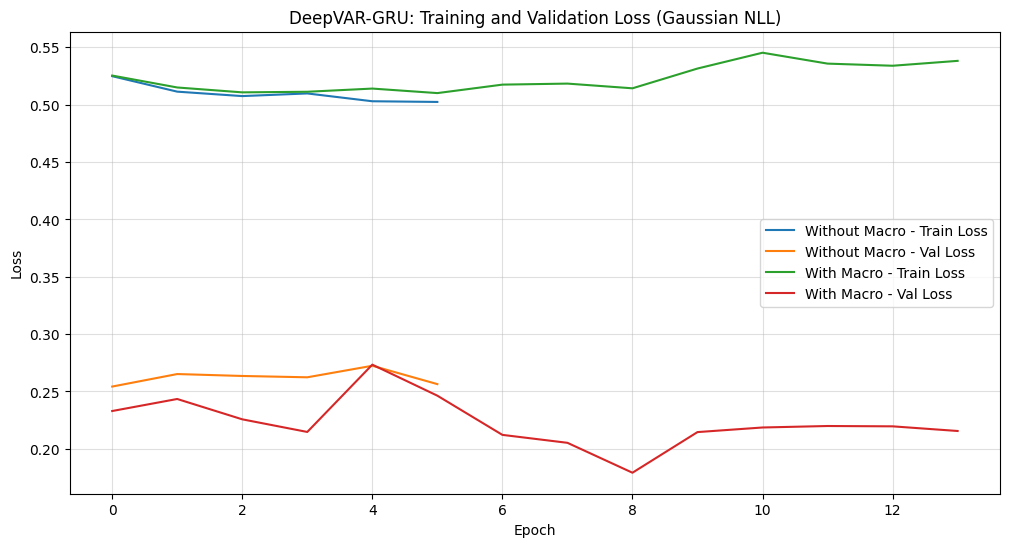

In [55]:
plt.figure(figsize=(12, 6))
plt.plot(history_without_macro.history["loss"], label="Without Macro - Train Loss")
plt.plot(history_without_macro.history["val_loss"], label="Without Macro - Val Loss")
plt.plot(history_with_macro.history["loss"], label="With Macro - Train Loss")
plt.plot(history_with_macro.history["val_loss"], label="With Macro - Val Loss")
plt.title("DeepVAR-GRU: Training and Validation Loss (Gaussian NLL)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.4)
plt.show()

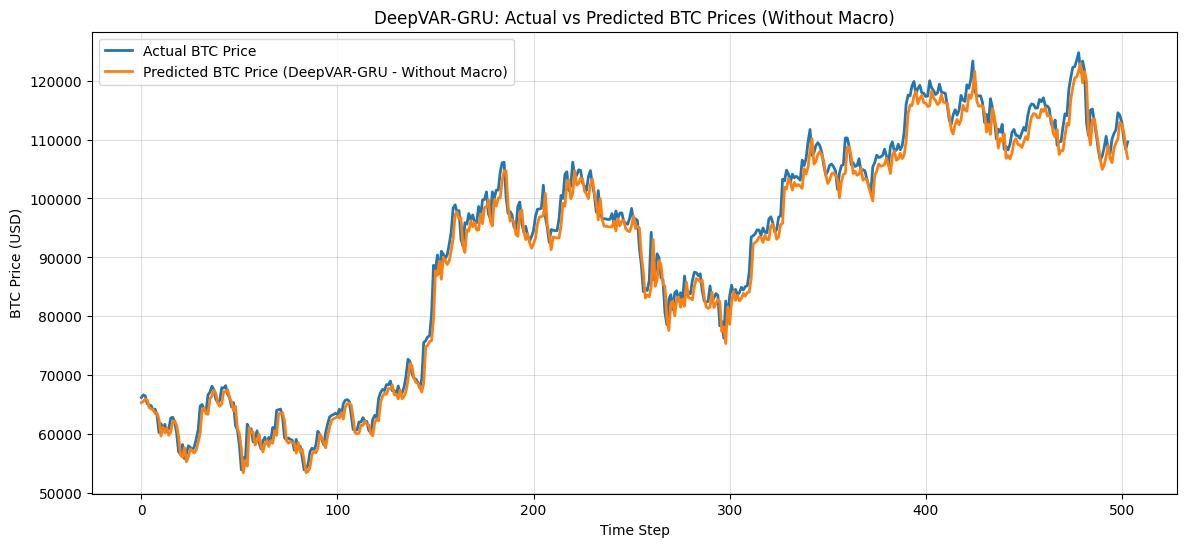

In [56]:
plt.figure(figsize=(14, 6))
plt.plot(actual_prices, label="Actual BTC Price", linewidth=2)
plt.plot(pred_price_1, label="Predicted BTC Price (DeepVAR-GRU - Without Macro)", linewidth=2)
plt.xlabel("Time Step")
plt.ylabel("BTC Price (USD)")
plt.title("DeepVAR-GRU: Actual vs Predicted BTC Prices (Without Macro)")
plt.legend()
plt.grid(True, alpha=0.4)
plt.show()

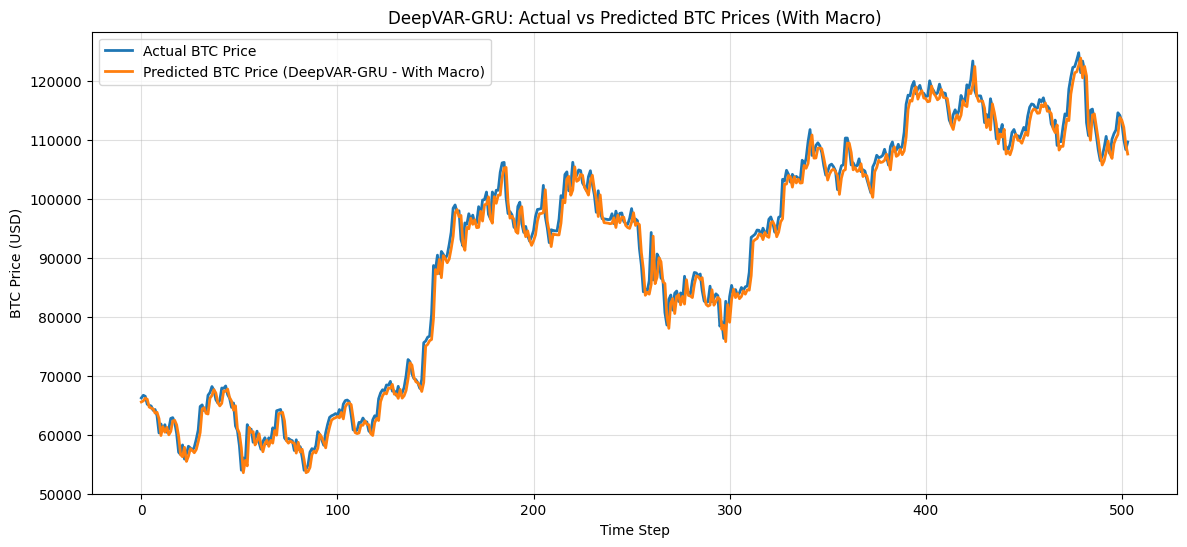

In [57]:
plt.figure(figsize=(14, 6))
plt.plot(actual_prices, label="Actual BTC Price", linewidth=2)
plt.plot(pred_price_2, label="Predicted BTC Price (DeepVAR-GRU - With Macro)", linewidth=2)
plt.xlabel("Time Step")
plt.ylabel("BTC Price (USD)")
plt.title("DeepVAR-GRU: Actual vs Predicted BTC Prices (With Macro)")
plt.legend()
plt.grid(True, alpha=0.4)
plt.show()